In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import random
import seaborn as sns
import xgboost as xgb, lightgbm as lgbm, catboost as catb

from matplotlib import pyplot as plt
from scipy.stats import shapiro, boxcox
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline

In [3]:
def line_reg(a1, a2):
    # Ищем коэффициенты линейной регрессии с помощью формул для парной регрессии,
    x = df[a1]
    y = df[a2]
    b1 = ((x * y).mean() - x.mean() * y.mean()) / ((x ** 2).mean() - x.mean() ** 2)
    print(b1)
    b0 = y.mean() - b1 * x.mean()
    print(b0)
    # Заполняем пропуски
    df[a2] = df[a2].fillna(b0 + b1*df[a1])

In [4]:
df = pd.read_csv('course_project_train.csv')

In [5]:
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [6]:
df.shape

(7500, 17)

In [7]:
df.iloc[0]

Home Ownership                            Own Home
Annual Income                               482087
Years in current job                           NaN
Tax Liens                                        0
Number of Open Accounts                         11
Years of Credit History                       26.3
Maximum Open Credit                         685960
Number of Credit Problems                        1
Months since last delinquent                   NaN
Bankruptcies                                     1
Purpose                         debt consolidation
Term                                    Short Term
Current Loan Amount                          1e+08
Current Credit Balance                       47386
Monthly Debt                                  7914
Credit Score                                   749
Credit Default                                   0
Name: 0, dtype: object

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  7

In [9]:
for colname in ['Tax Liens', 'Number of Open Accounts', 'Number of Credit Problems']:
    df[colname] = df[colname].astype(int)

In [10]:
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [11]:
# Обрабатываем выбросы по 'Maximum Open Credit'
df.loc[df['Maximum Open Credit'] > 1000000000, 'Maximum Open Credit'] = df.loc[df['Maximum Open Credit'] > 1000000000, 'Maximum Open Credit']/1000
df.loc[df['Maximum Open Credit'] > 100000000, 'Maximum Open Credit'] = df.loc[df['Maximum Open Credit'] > 100000000, 'Maximum Open Credit']/100
df.loc[df['Maximum Open Credit'] > 10000000, 'Maximum Open Credit'] = df.loc[df['Maximum Open Credit'] > 10000000, 'Maximum Open Credit']/10

In [12]:
# Обрабатываем выбросы по 'Current Loan Amount'
df.loc[df['Current Loan Amount'] == 99999999, 'Current Loan Amount'] = df.loc[df['Current Loan Amount'] != 99999999, 'Current Loan Amount'].mean()

In [13]:
# Обрабатываем выбросы по 'Number of Open Accounts'
df.loc[df['Number of Open Accounts'] > 24, 'Number of Open Accounts'] = df.loc[df['Number of Open Accounts'] < 24, 'Number of Open Accounts'].mean()

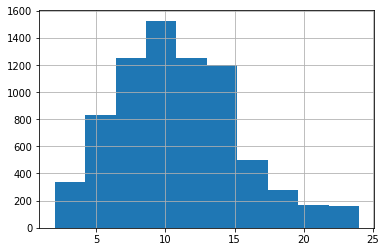

In [14]:
df['Number of Open Accounts'].hist()

In [15]:
# Обрабатываем выбросы по 'Annual Income'
df.loc[df['Annual Income'] > 5000000, 'Annual Income'] = df.loc[df['Annual Income'] < 5000000, 'Annual Income'].mean()

In [16]:
# Смотрим распределение значений по ключевому параметру
df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [17]:
# Делим выборку на 2 по ключевому параметру
df_good = df.loc[df['Credit Default'] == 0]
df_not_good = df.loc[df['Credit Default'] == 1]

Смотрим может какието параметры сильно оличаются

In [18]:
df_good.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,4.359000e+03,5387.000000,5387.000000,5387.000000,5.387000e+03,5387.000000,2436.000000,5377.000000,5387.000000,5.387000e+03,5387.000000,4359.000000,5387.0
mean,1.368983e+06,0.025988,10.771857,18.408168,6.739736e+05,0.163727,34.656814,0.116794,302110.501504,2.937194e+05,18176.425469,723.577885,0.0
std,7.147542e+05,0.256502,4.344039,6.959349,7.239136e+05,0.480127,21.516233,0.344130,164804.711551,3.359989e+05,11917.013432,25.412545,0.0
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,11242.000000,0.000000e+00,0.000000,590.000000,0.0
25%,8.663525e+05,0.000000,8.000000,13.700000,2.895860e+05,0.000000,17.000000,0.000000,179806.000000,1.145035e+05,9894.500000,713.000000,0.0
50%,1.225747e+06,0.000000,10.000000,17.100000,4.937460e+05,0.000000,32.000000,0.000000,309024.390347,2.092850e+05,15939.000000,732.000000,0.0
75%,1.683115e+06,0.000000,13.000000,22.000000,8.233610e+05,0.000000,50.000000,0.000000,366322.000000,3.629095e+05,23717.500000,742.000000,0.0
max,4.906028e+06,7.000000,24.000000,51.900000,9.541136e+06,7.000000,118.000000,4.000000,789030.000000,6.506797e+06,136679.000000,751.000000,0.0


In [19]:
df_not_good.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,1.584000e+03,2113.000000,2113.000000,2113.000000,2.113000e+03,2113.000000,983.000000,2109.000000,2113.000000,2.113000e+03,2113.000000,1584.000000,2113.0
mean,1.209076e+06,0.040700,11.039319,18.086228,5.798982e+05,0.185991,34.781282,0.118065,326651.044013,2.799256e+05,18666.352106,2327.548611,1.0
std,6.348094e+05,0.306572,4.382239,7.244804,5.517541e+05,0.542644,22.121493,0.354961,186027.080635,2.659432e+05,11947.197046,2787.985441,0.0
min,1.940280e+05,0.000000,2.000000,4.500000,0.000000e+00,0.000000,0.000000,0.000000,21472.000000,0.000000e+00,0.000000,585.000000,1.0
25%,7.726730e+05,0.000000,8.000000,13.100000,2.562560e+05,0.000000,15.000000,0.000000,181610.000000,1.124610e+05,10534.000000,704.000000,1.0
50%,1.055916e+06,0.000000,10.758936,16.700000,4.420900e+05,0.000000,33.000000,0.000000,290576.000000,2.101020e+05,16390.000000,730.500000,1.0
75%,1.487505e+06,0.000000,14.000000,21.500000,7.279580e+05,0.000000,52.000000,0.000000,444708.000000,3.536470e+05,24057.000000,6162.500000,1.0
max,4.867800e+06,5.000000,24.000000,57.700000,6.639358e+06,5.000000,86.000000,4.000000,788634.000000,3.944514e+06,104036.000000,7510.000000,1.0


In [20]:
for cat_colname in df.select_dtypes(include='object').columns:
    print(str(cat_colname) 
          + '\n\n'
          + 'Total count      ' 
          + str(df[cat_colname].count())
          + '\n' 
          + str(df[cat_colname].value_counts()) 
          + '\n' 
          + str(df[cat_colname].value_counts()/df[cat_colname].count())
          + '\n'
          + '\n'
          + '\n\n'
          + 'Total count      ' 
          + str(df_good[cat_colname].count())
          + '\n' 
          + str(df_good[cat_colname].value_counts()) 
          + '\n' 
          + str(df_good[cat_colname].value_counts()/df_good[cat_colname].count())
          + '\n'
          + '\n'
          + '\n\n'
          + 'Total count      ' 
          + str(df_not_good[cat_colname].count())
          + '\n' 
          + str(df_not_good[cat_colname].value_counts()) 
          + '\n' 
          + str(df_not_good[cat_colname].value_counts()/df_not_good[cat_colname].count())
          + '\n'
          + '*' * 100 + '\n')

Home Ownership

Total count      7500
Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
Home Mortgage    0.484933
Rent             0.427200
Own Home         0.086267
Have Mortgage    0.001600
Name: Home Ownership, dtype: float64



Total count      5387
Home Mortgage    2721
Rent             2201
Own Home          455
Have Mortgage      10
Name: Home Ownership, dtype: int64
Home Mortgage    0.505105
Rent             0.408576
Own Home         0.084463
Have Mortgage    0.001856
Name: Home Ownership, dtype: float64



Total count      2113
Rent             1003
Home Mortgage     916
Own Home          192
Have Mortgage       2
Name: Home Ownership, dtype: int64
Rent             0.474681
Home Mortgage    0.433507
Own Home         0.090866
Have Mortgage    0.000947
Name: Home Ownership, dtype: float64
****************************************************************************************************

Years in current j

In [20]:
len(df) - df.count()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

Обработка пропусков

In [21]:
# Заполняем пропуски следующим и предыдущим значением чтобы сильно не отклоняться от распределения
df['Years in current job'] = df['Years in current job'].fillna(method='pad')
df['Years in current job'] = df['Years in current job'].fillna(method='bfill') 

In [22]:
# Заполняем пропуски следующим и предыдущим значением чтобы сильно не отклоняться от распределения
df['Credit Score'] = df['Credit Score'].fillna(method='pad')
df['Credit Score'] = df['Credit Score'].fillna(method='bfill') 

In [23]:
df.loc[df['Months since last delinquent'] == 0, {'Months since last delinquent'}].count()

Months since last delinquent    18
dtype: int64

In [24]:
# Очень много данных отсутствует по месяцам с проследней просрочки, и очень мало данных с 0,
# предполагаю что 0 это отсутствие просрочек. 
# Похоже на то, что при отсутствии просрочек данные просто не заполнялись.
df['Months since last delinquent'] = df['Months since last delinquent'].fillna(0)

In [25]:
df.corr()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
Annual Income,1.000000,0.059351,0.213026,0.209831,0.313864,-0.013796,0.019254,-0.061765,0.442679,0.354678,0.575513,-0.041925,-0.101318
Tax Liens,0.059351,1.000000,-0.003376,0.009109,-0.008204,0.595339,0.070684,0.057360,0.030081,-0.010195,0.027211,0.002198,0.024368
Number of Open Accounts,0.213026,-0.003376,1.000000,0.143320,0.329152,-0.013004,0.045339,-0.015143,0.195240,0.260344,0.406117,0.010568,0.027621
Years of Credit History,0.209831,0.009109,0.143320,1.000000,0.234632,0.071259,0.097312,0.085699,0.142617,0.217856,0.191978,-0.008057,-0.020567
Maximum Open Credit,0.313864,-0.008204,0.329152,0.234632,1.000000,-0.110463,-0.089568,-0.126578,0.295310,0.735940,0.356649,-0.014793,-0.062136
Number of Credit Problems,-0.013796,0.595339,-0.013004,0.071259,-0.110463,1.000000,0.108892,0.730751,-0.061211,-0.124137,-0.042252,-0.016682,0.020088
Months since last delinquent,0.019254,0.070684,0.045339,0.097312,-0.089568,0.108892,1.000000,0.067623,-0.016895,-0.082444,-0.002832,0.003972,0.010110
Bankruptcies,-0.061765,0.057360,-0.015143,0.085699,-0.126578,0.730751,0.067623,1.000000,-0.091432,-0.142849,-0.079579,-0.027876,0.001648
Current Loan Amount,0.442679,0.030081,0.195240,0.142617,0.295310,-0.061211,-0.016895,-0.091432,1.000000,0.340201,0.410523,0.015495,0.064414
Current Credit Balance,0.354678,-0.010195,0.260344,0.217856,0.735940,-0.124137,-0.082444,-0.142849,0.340201,1.000000,0.504964,-0.002087,-0.019522


In [26]:
# Годовой доход влияет на месячный платеж 0,585 (Коэффициент кореляции)
# Следовательно можно составить уравнение линейной регрессии
line_reg('Monthly Debt', 'Annual Income')

33.225502016109395
717856.0730326801


In [27]:
# Наличие проблемных кредитов почти всегда приводит к бакротству, 0,73 (Коэффициент кореляции)
# Следовательно можно составить уравнение линейной регрессии
line_reg('Number of Credit Problems', 'Bankruptcies')

0.5094181258504767
0.03055093570400297


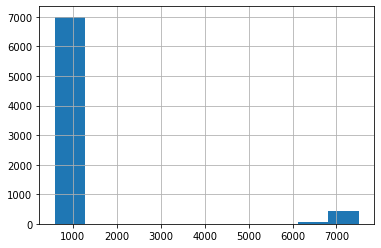

In [28]:
df['Credit Score'].hist()

In [29]:
# Из данных видно, что кредитный рейтинг больше 1000 явно выбивается из общей картины
df.loc[df['Credit Score'] > 1000, 'Credit Score'] = df[df['Credit Score'] > 1000]['Credit Score']/10

In [30]:
len(df) - df.count()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
dtype: int64

In [31]:
df['ID'] = df.index.tolist()

In [32]:
# доп. параметр "з/п в месяц"
df['ZP'] = df['Annual Income']/12

In [33]:
# доп. параметр "Какая част з/п уходит на кредит"
df['prec_amount'] = df['Monthly Debt']/df['ZP']

In [34]:
# доп. параметр "Есть ли налоговые обременения"
df['Tax_bool'] = df['Tax Liens'] > 0
df.loc[df['Tax_bool'] == True, 'Tax_bool'] = 1
df.loc[df['Tax_bool'] == False, 'Tax_bool'] = 0

In [35]:
# доп. параметр "Сколько месяцев осталось до погашения кредита"
df['credit_mon'] = np.round(df.loc[df['Monthly Debt'] != 0, 'Current Loan Amount']/df.loc[df['Monthly Debt'] != 0, 'Monthly Debt'])

In [36]:
# Если кредита нет, заполняем 0
df['credit_mon'] = df['credit_mon'].fillna(0)

In [37]:
# доп. параметр "Имелись ли проблемы с кредитами"
df['have_credit_problem'] = df['Number of Credit Problems'] > 0
df.loc[df['have_credit_problem'] == True, 'have_credit_problem'] = 1
df.loc[df['have_credit_problem'] == False, 'have_credit_problem'] = 0

In [38]:
df.to_csv('course_project_train_process.csv', index=False, encoding='utf-8')

In [39]:
df = pd.read_csv('course_project_train_process.csv')

In [40]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES)

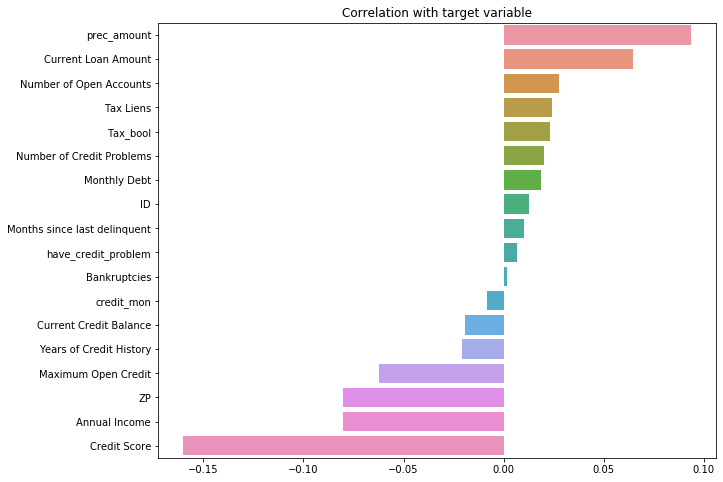

In [41]:
# Посмотрим корреляцию с ключевым параметром
corr_with_target = df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

In [42]:
def hist_param(param, target, DataF, we, hi):
    plt.figure(figsize=(we, hi))

    sns.countplot(x=param, hue=target, data=DataF)
    plt.title(param + ' grouped by target variable')
    plt.legend(title='Target', loc='upper right')

    plt.show()    

In [43]:
def grafic(param, target, sample_val, wi, hi):
    limit_bal_with_target_s = df[[param, TARGET_NAME]].sample(sample_val)
    limit_bal_s = limit_bal_with_target_s[param]
    limit_bal_target_0 = limit_bal_s[limit_bal_with_target_s[TARGET_NAME] == 0]
    limit_bal_target_1 = limit_bal_s[limit_bal_with_target_s[TARGET_NAME] == 1]
    
    plt.figure(figsize=(wi, hi))

    sns.kdeplot(limit_bal_target_0, shade=True, label='No good', color='g')
    sns.kdeplot(limit_bal_target_1, shade=True, label='Good', color='r')

    plt.xlabel(param)
    plt.title(param + ' grouped by target variable')
    plt.show()
    return limit_bal_with_target_s, limit_bal_s, limit_bal_target_0, limit_bal_target_1

In [44]:
def conf_interval(param, target, DataF, wi, hi):
    plt.figure(figsize=(wi, hi))

    sns.pointplot(x=target, y=param, data=DataF, capsize=.1)

    plt.title('Confidence intervals (95 %) for ' + param)
    plt.show()

In [45]:
def pirson(param, target, id_val, value1, value2):
    pay1_and_target_s = df.loc[df[param].isin([value1, value2]), [id_val, param, target]].sample(2000)
    table = pay1_and_target_s.pivot_table(values=id_val, index=param, columns=target, aggfunc='count')
    chi2, p, dof, expected = chi2_contingency(table, correction=False)
    return p

In [46]:
def box_cox(param):
    data_t, lmbda = boxcox(param)
#     plt.figure(figsize=(10,5))
#     sns.kdeplot(param, shade=True, label='No default', color='g')
#     plt.figure(figsize=(10,5))
#     sns.kdeplot(data_t, shade=True, label='Default', color='r')
    return data_t

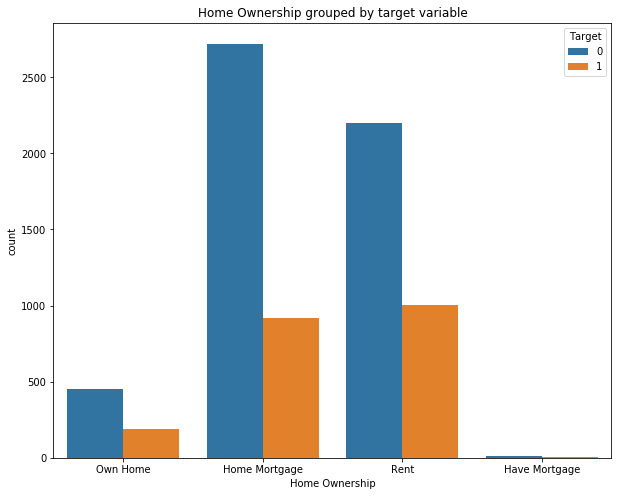

In [47]:
hist_param('Home Ownership', TARGET_NAME, df, 10, 8)

Значения 'Own Home' и 'Home Mortgage' имеют схожие доли в разрезе целевой переменной.

**Гипотеза** 

* Нулевая гипотеза: ожидаемые и наблюдаемые частоты согласованы
* Альтернативная гипотеза: отклонения в частотах выходят за рамки случайных колебаний, расхождения статистически значимы
* Критерий: Хи-квадрат Пирсона
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

In [48]:
pirson('Home Ownership', 'Credit Default', 'ID', 'Own Home', 'Home Mortgage')

0.26685118473304276

P-value получилось больше выбранного уровня значимости, соответственно гипотезу принимаем.

In [49]:
# Объединяем признаки 'Own Home' и 'Home Mortgage'
df.loc[df['Home Ownership'] == 'Own Home', 'Home Ownership'] = 'Home Mortgage'
# Переводим признаки в числовое значение
df.loc[df['Home Ownership'] == 'Home Mortgage', 'Home Ownership'] = 1
df.loc[df['Home Ownership'] == 'Rent', 'Home Ownership'] = 2
df.loc[df['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 3

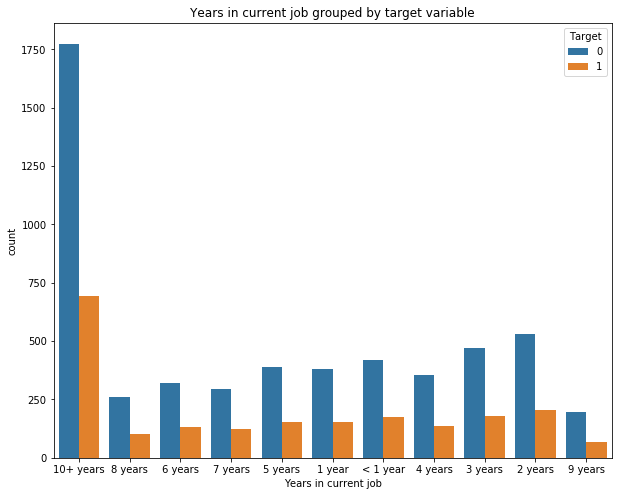

In [50]:
hist_param('Years in current job', TARGET_NAME, df, 10, 8)

In [51]:
pirson('Years in current job', 'Credit Default', 'ID', '10+ years', '9 years')

0.29835529691994517

In [52]:
pirson('Years in current job', 'Credit Default', 'ID', '10+ years', '8 years')

0.8876671013615001

In [53]:
pirson('Years in current job', 'Credit Default', 'ID', '10+ years', '7 years')

0.8517455314585705

In [56]:
pirson('Years in current job', 'Credit Default', 'ID', '10+ years', '6 years')

0.5560760091336611

In [57]:
pirson('Years in current job', 'Credit Default', 'ID', '10+ years', '5 years')

0.5304131348087568

In [58]:
pirson('Years in current job', 'Credit Default', 'ID', '10+ years', '4 years')

0.48038016284798557

In [59]:
pirson('Years in current job', 'Credit Default', 'ID', '10+ years', '3 years')

0.3369763287920681

In [60]:
pirson('Years in current job', 'Credit Default', 'ID', '10+ years', '2 years')

0.4869186005876548

In [61]:
pirson('Years in current job', 'Credit Default', 'ID', '10+ years', '1 year')

0.8297076838078625

In [62]:
pirson('Years in current job', 'Credit Default', 'ID', '10+ years', '< 1 year')

0.8496532834630468

По результатам вычислений можно сделать вывод, что количество лет на текущей работе одинаково влияет на целевую переменную.

Как это поможет?

Будем эксперементировать.

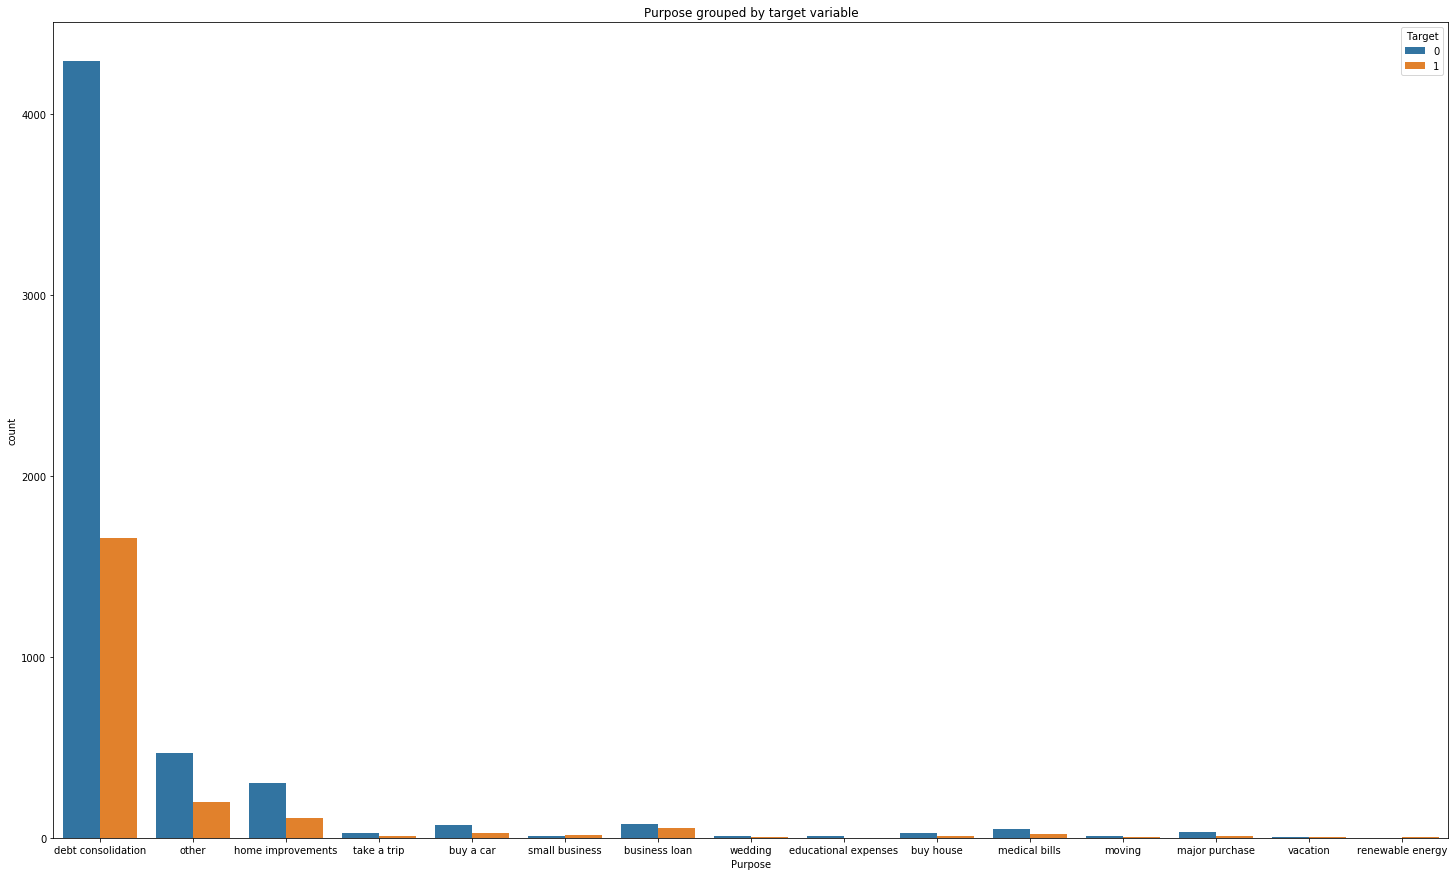

In [63]:
hist_param('Purpose', TARGET_NAME, df, 25, 15)

In [64]:
pirson('Purpose', 'Credit Default', 'ID', 'debt consolidation', 'other')

0.25487400772523544

In [65]:
pirson('Purpose', 'Credit Default', 'ID', 'debt consolidation', 'home improvements')

0.6250271997708428

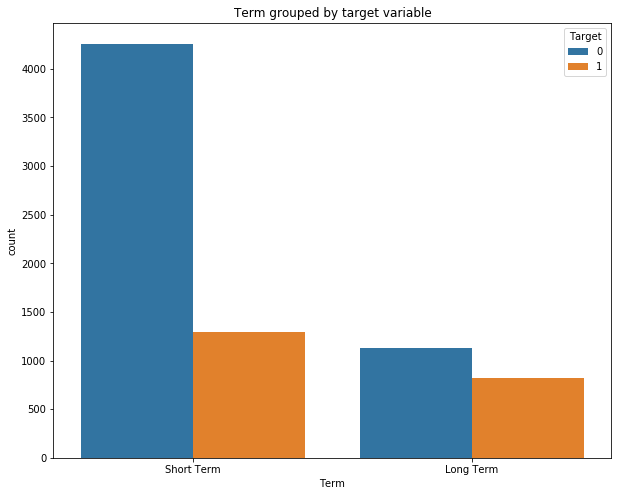

In [66]:
hist_param('Term', TARGET_NAME, df, 10, 8)

На графике видно, что люди которые берут кредит на длительный срок чаще допускают просрочки.

In [67]:
# переведем для удобства в числовые значения
df.loc[df['Term'] == 'Short Term', 'Term'] = 0
df.loc[df['Term'] == 'Long Term', 'Term'] = 1

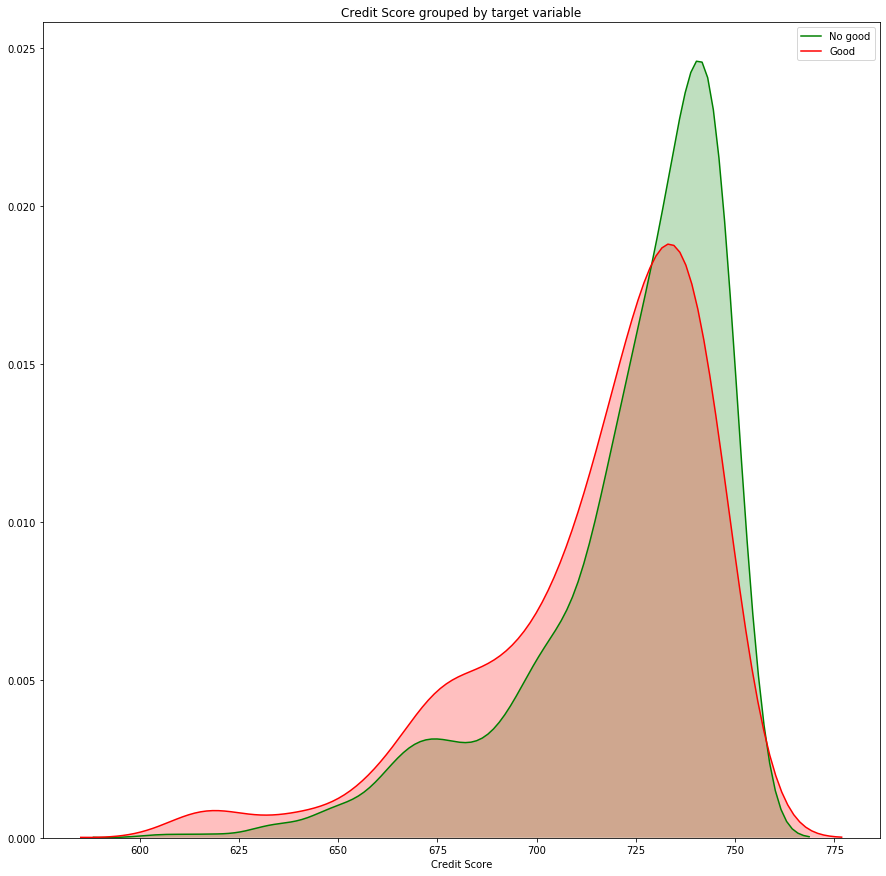

In [68]:
limit_s, limit, limit_0, limit_1 = grafic('Credit Score', TARGET_NAME, 1000, 15, 15)

In [69]:
# Проверяем является ли распределение нормальным
shapiro(limit)

(0.8592579364776611, 5.659739957220492e-29)

Значение p-value < 0.05, распределение не является нормальным.
Для проверки гипотезы о равенстве средних будем использовать непараметрический - критерием Манна-Уитни

In [70]:
mannwhitneyu(limit_0, limit_1)

MannwhitneyuResult(statistic=80209.0, pvalue=1.456522743033733e-06)

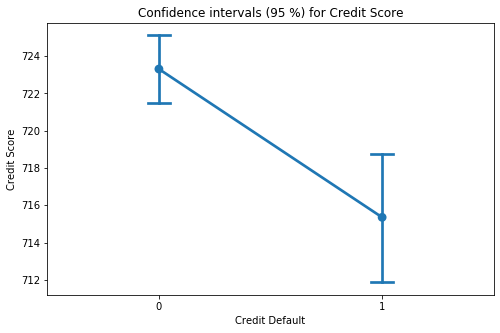

In [71]:
conf_interval('Credit Score', TARGET_NAME, limit_s, 8, 5)

По данному графику так же видно, что интервалы, в которых с 95% вероятностью должны находится истинные мат. ожидания этих двух групп, не пересекаются, что подтверждает результаты полученные с помощью критерия Манна-Уитни.

Это означает, что группы из которых взяты данные выборки, с допускаемой нами вероятностью (95%), имеют различные распределения и этот признак может быть полезен для определения значения целевой переменной.


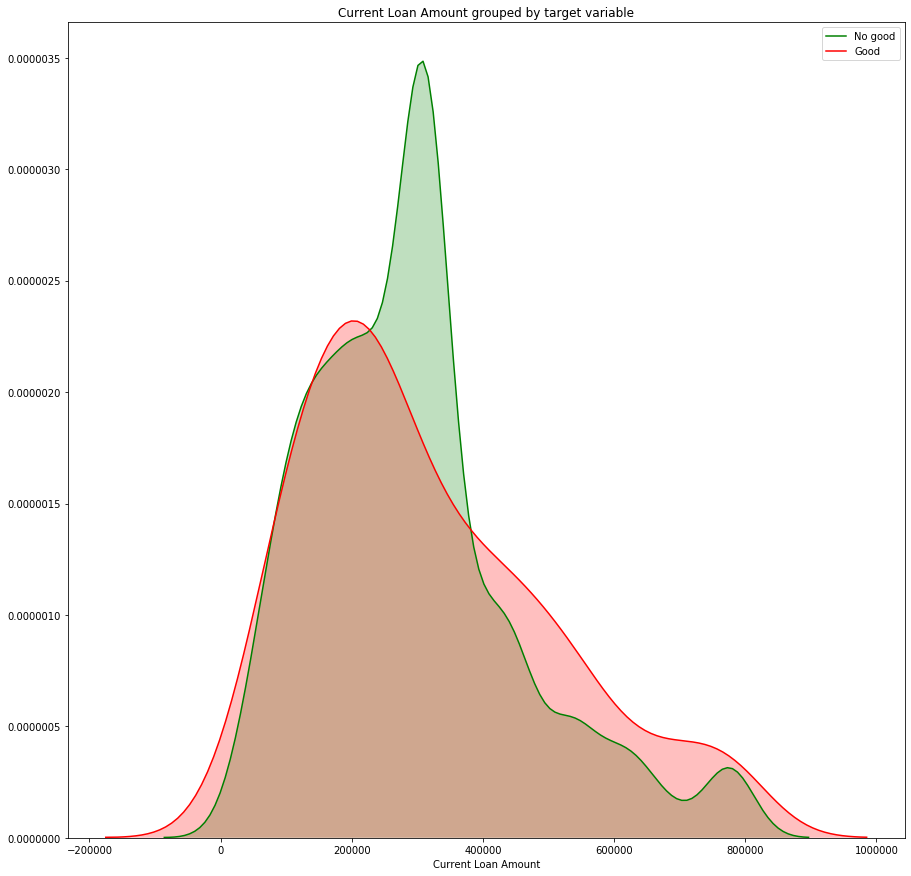

In [72]:
limit_s, limit, limit_0, limit_1 = grafic('Current Loan Amount', TARGET_NAME, 1000, 15, 15)

In [73]:
# Проверяем является ли распределение нормальным
shapiro(limit)

(0.9328432083129883, 8.72559223969804e-21)

In [74]:
mannwhitneyu(limit_0, limit_1)

MannwhitneyuResult(statistic=94046.0, pvalue=0.18757643768337195)

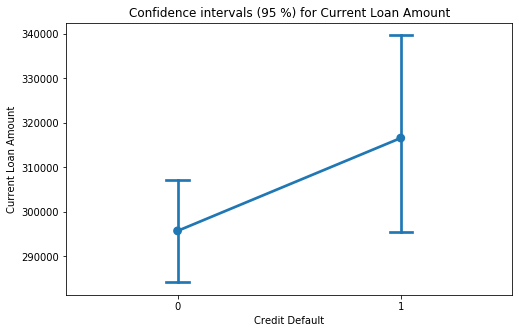

In [75]:
conf_interval('Current Loan Amount', TARGET_NAME, limit_s, 8, 5)

Данные нельзя использовать в таком виде т.к. распределения пересекаются

Нормализуем параметр 'Current Loan Amount'

In [76]:
df['Current Loan Amount'] = box_cox(df['Current Loan Amount'])

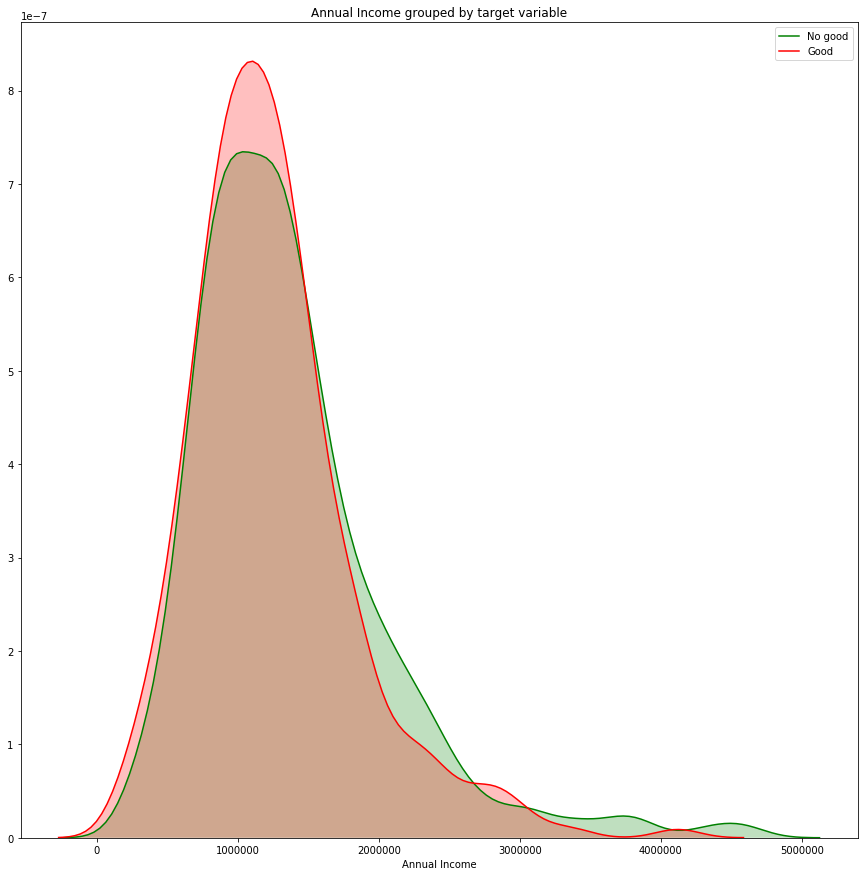

In [77]:
limit_s, limit, limit_0, limit_1 = grafic('Annual Income', TARGET_NAME, 1000, 15, 15)

In [78]:
# Проверяем является ли распределение нормальным
shapiro(limit)

(0.891636848449707, 6.472515596784147e-26)

In [79]:
mannwhitneyu(limit_0, limit_1)

MannwhitneyuResult(statistic=93283.0, pvalue=0.016312662606918427)

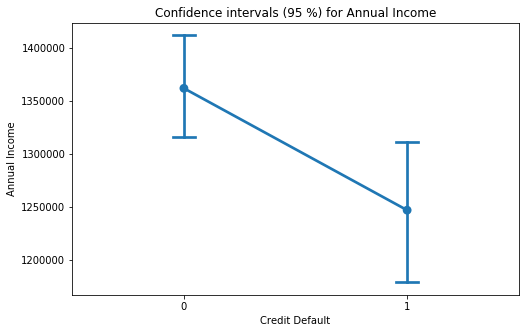

In [80]:
conf_interval('Annual Income', TARGET_NAME, limit_s, 8, 5)

Данные нельзя использовать в таком виде т.к. распределения пересекаются

Нормализуем параметр 'Annual Income'

In [81]:
df['Annual Income'] = box_cox(df['Annual Income'])

Нормализуем параметр 'Number of Open Accounts'

In [82]:
df['Number of Open Accounts'] = box_cox(df['Number of Open Accounts'])

Нормализуем параметр'Number of Open Accounts'

In [83]:
df['Years of Credit History'] = box_cox(df['Years of Credit History'])

Нормализуем параметр 'ZP'

In [84]:
df['ZP'] = box_cox(df['ZP'])

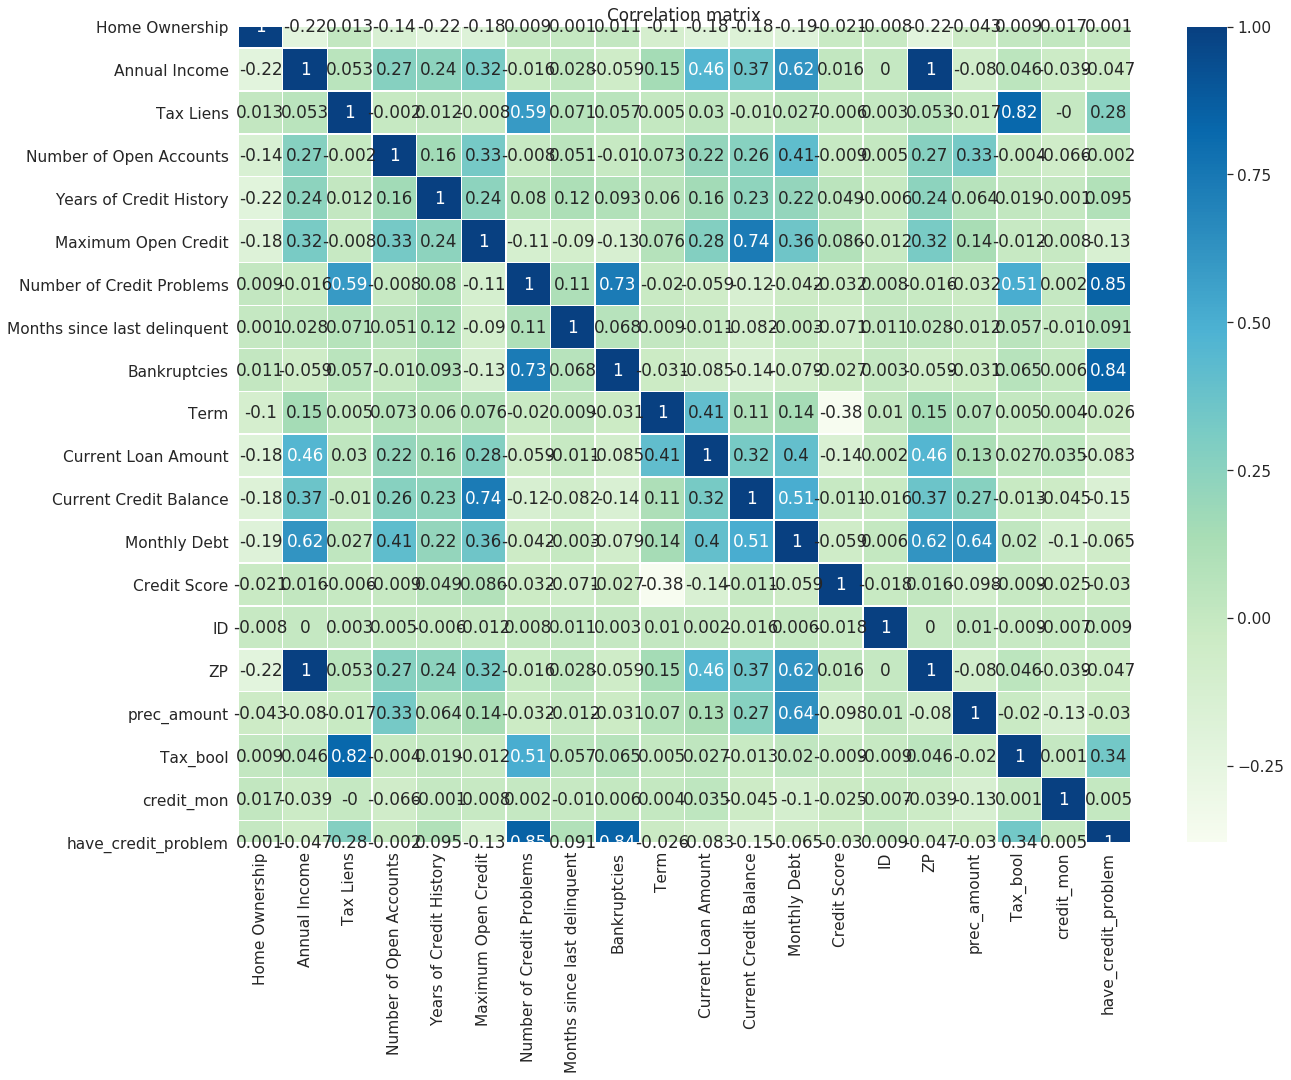

In [85]:
# Корреляция параметров
plt.figure(figsize = (20,15))

sns.set(font_scale=1.4)
sns.heatmap(df[BASE_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

In [86]:
df.to_csv('course_project_train_process_2.csv', index=False, encoding='utf-8')

In [87]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME, 'ID'] + BASE_FEATURE_NAMES).tolist()
NUM_FEATURE_NAMES = ['Years of Credit History', 'prec_amount', 'Tax_bool', 'ZP',
                     'Maximum Open Credit', 'Months since last delinquent', 'Credit Score',
                     'Number of Open Accounts', 'Term', 'Current Loan Amount', 'Home Ownership',
                     'Current Credit Balance', 'Tax Liens', 'Number of Credit Problems',
                     'Bankruptcies', 'credit_mon', 
                     'have_credit_problem', 'Annual Income', 'Monthly Debt'
                    ]
FEATURE_NAMES_SELECTED = NUM_FEATURE_NAMES + NEW_FEATURE_NAMES

In [88]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [89]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [90]:
df = pd.read_csv('course_project_train_process_2.csv')

In [91]:
scaler = StandardScaler()

df_norm = df.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

df = df_norm.copy()

In [92]:
SCALER_FILE_PATH = 'scaler.pkl'
TRAIN_FULL_PATH = 'training_project_train_full.csv'
TRAIN_PART_PATH = 'training_project_train_part_b.csv'
TEST_PART_PATH = 'training_project_test_part.csv'

In [93]:
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

In [94]:
# делим выборку на тренировочную и тестовую
X = df[FEATURE_NAMES_SELECTED]
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=211)

In [95]:
# Балансировка данных
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

/home/aleksandr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  """
/home/aleksandr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  


0    4047
1    3156
Name: Credit Default, dtype: int64

In [96]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

Построение и оценка базовых моделей

Логистическая регрессия

In [97]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.64      0.78      0.70      4047
           1       0.61      0.45      0.51      3156

    accuracy                           0.63      7203
   macro avg       0.62      0.61      0.61      7203
weighted avg       0.63      0.63      0.62      7203

TEST

              precision    recall  f1-score   support

           0       0.77      0.76      0.77      1340
           1       0.42      0.43      0.43       535

    accuracy                           0.67      1875
   macro avg       0.60      0.60      0.60      1875
weighted avg       0.67      0.67      0.67      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1022  318
1                304  231


/home/aleksandr/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


k ближайших соседей

In [98]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.76      0.81      0.78      4047
           1       0.73      0.67      0.70      3156

    accuracy                           0.75      7203
   macro avg       0.75      0.74      0.74      7203
weighted avg       0.75      0.75      0.75      7203

TEST

              precision    recall  f1-score   support

           0       0.73      0.70      0.72      1340
           1       0.33      0.37      0.35       535

    accuracy                           0.60      1875
   macro avg       0.53      0.53      0.53      1875
weighted avg       0.62      0.60      0.61      1875

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               937  403
1               338  197


Бустинговые алгоритмы

XGBoost

In [99]:
model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      4047
           1       0.98      0.98      0.98      3156

    accuracy                           0.98      7203
   macro avg       0.98      0.98      0.98      7203
weighted avg       0.98      0.98      0.98      7203

TEST

              precision    recall  f1-score   support

           0       0.76      0.79      0.77      1340
           1       0.41      0.36      0.38       535

    accuracy                           0.67      1875
   macro avg       0.58      0.58      0.58      1875
weighted avg       0.66      0.67      0.66      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1054  286
1                340  195


LightGBM

In [100]:
model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.92      0.93      0.93      4047
           1       0.91      0.90      0.91      3156

    accuracy                           0.92      7203
   macro avg       0.92      0.92      0.92      7203
weighted avg       0.92      0.92      0.92      7203

TEST

              precision    recall  f1-score   support

           0       0.77      0.76      0.77      1340
           1       0.42      0.43      0.43       535

    accuracy                           0.67      1875
   macro avg       0.60      0.60      0.60      1875
weighted avg       0.67      0.67      0.67      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1023  317
1                303  232


CatBoost

In [101]:
model_catb = catb.CatBoostClassifier(n_estimators=200, max_depth=3, 
                                     silent=True, random_state=21) 
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.74      0.77      0.75      4047
           1       0.69      0.66      0.67      3156

    accuracy                           0.72      7203
   macro avg       0.72      0.71      0.71      7203
weighted avg       0.72      0.72      0.72      7203

TEST

              precision    recall  f1-score   support

           0       0.81      0.73      0.77      1340
           1       0.46      0.57      0.51       535

    accuracy                           0.68      1875
   macro avg       0.63      0.65      0.64      1875
weighted avg       0.71      0.68      0.69      1875

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               977  363
1               231  304


Выбор лучшей модели и подбор гиперпараметро

In [102]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)

In [103]:
params = {'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500],
          'max_depth':[3, 5, 7]}

In [104]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [105]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)

CPU times: user 15.3 s, sys: 884 ms, total: 16.2 s
Wall time: 1min 45s


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=<catboost.core.CatBoostClassifier object at 0x7ffb43036950>,
                   iid='warn', n_iter=10, n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, 7],
                                        'n_estimators': [50, 100, 200, 500, 700,
                                                         1000, 1200, 1500]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='f1', verbose=0)

In [106]:
rs.best_params_

{'n_estimators': 1000, 'max_depth': 7}

In [107]:
rs.best_score_

0.2721233286034333

In [110]:
# Полученная модель с окончательными параметрами
final_model = catb.CatBoostClassifier(n_estimators=1000, max_depth=7, l2_leaf_reg=10, 
                                     silent=True, random_state=21) 

In [111]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

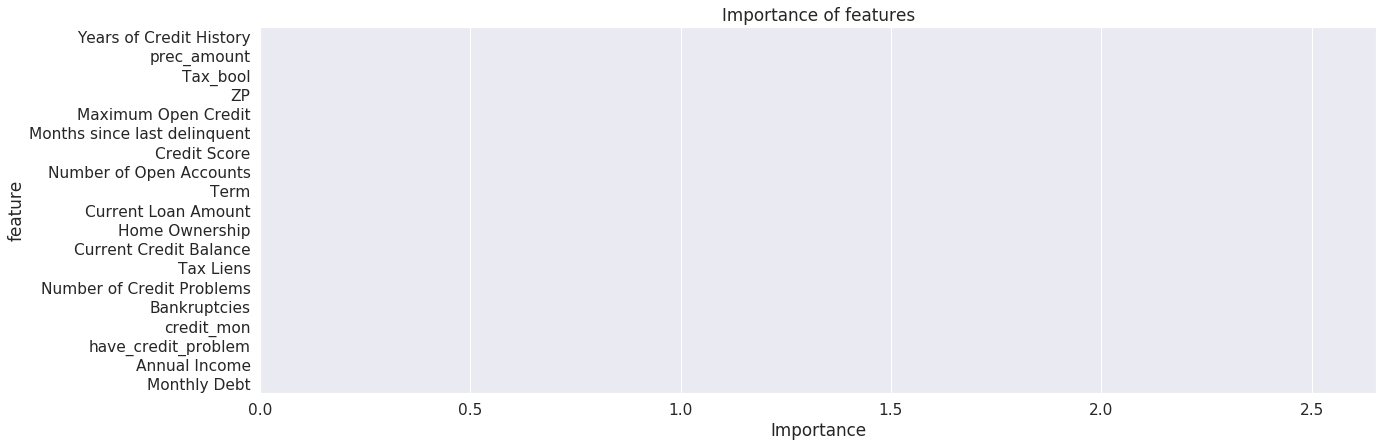

In [112]:
important_features_top = show_feature_importances(X_train.columns, final_model.feature_importances_, get_top=15)

In [113]:
# Проводим окончательное тестирование модели и дообучаем ее на оставшихся данных. 
final_model.fit(X_train[important_features_top], y_train)

y_train_pred = final_model.predict(X_train[important_features_top])
y_test_pred = final_model.predict(X_test[important_features_top])
y_test_pred_probs = final_model.predict_proba(X_test[important_features_top])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      4047
           1       0.94      0.94      0.94      3156

    accuracy                           0.94      7203
   macro avg       0.94      0.94      0.94      7203
weighted avg       0.94      0.94      0.94      7203

TEST

              precision    recall  f1-score   support

           0       0.78      0.80      0.79      1340
           1       0.46      0.43      0.44       535

    accuracy                           0.69      1875
   macro avg       0.62      0.61      0.61      1875
weighted avg       0.69      0.69      0.69      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1066  274
1                305  230


Модель с новыми параметрами оказалась хуже.
Методом подбора параметров выяснилось, что данные параметры дают наилучший результат.
При установке параметра l2_leaf_reg показатели модели снижаются, из этого можно сделать вывод, что модель еще не до конца обучена и рисков переобучения пока нет.

In [148]:

final_model = catb.CatBoostClassifier(n_estimators=2500, max_depth=3, #l2_leaf_reg=3,
                                     silent=True, random_state=21) 
final_model.fit(X_train[important_features_top], y_train)

y_train_pred = final_model.predict(X_train[important_features_top])
y_test_pred = final_model.predict(X_test[important_features_top])
y_test_pred_probs = final_model.predict_proba(X_test[important_features_top])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.75      0.78      0.77      4047
           1       0.70      0.67      0.69      3156

    accuracy                           0.73      7203
   macro avg       0.73      0.73      0.73      7203
weighted avg       0.73      0.73      0.73      7203

TEST

              precision    recall  f1-score   support

           0       0.81      0.73      0.77      1340
           1       0.46      0.58      0.52       535

    accuracy                           0.69      1875
   macro avg       0.64      0.66      0.64      1875
weighted avg       0.71      0.69      0.70      1875

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               984  356
1               226  309


Из финальной модели видно, что точность нашей модели по предсказанию параметра "Default" немного не дотягивет до 50%, по остольным параметрам модель получилась довольно не плохая и ее можно испльзовать для предсказания результатов.

In [149]:
# Обработка входящих данных
def process_data(prc_df):
    prc_df.loc[prc_df['Annual Income'] > 5000000, 'Annual Income'] = prc_df.loc[prc_df['Annual Income'] < 5000000, 'Annual Income'].mean()
    prc_df.loc[prc_df['Maximum Open Credit'] > 1000000000, 'Maximum Open Credit'] = prc_df.loc[prc_df['Maximum Open Credit'] > 1000000000, 'Maximum Open Credit']/1000
    prc_df.loc[prc_df['Maximum Open Credit'] > 100000000, 'Maximum Open Credit'] = prc_df.loc[prc_df['Maximum Open Credit'] > 100000000, 'Maximum Open Credit']/100
    prc_df.loc[prc_df['Maximum Open Credit'] > 10000000, 'Maximum Open Credit'] = prc_df.loc[prc_df['Maximum Open Credit'] > 10000000, 'Maximum Open Credit']/10    
    prc_df.loc[prc_df['Current Loan Amount'] == 99999999, 'Current Loan Amount'] = prc_df.loc[prc_df['Current Loan Amount'] != 99999999, 'Current Loan Amount'].mean()
    prc_df.loc[prc_df['Number of Open Accounts'] > 24, 'Number of Open Accounts'] = prc_df.loc[prc_df['Number of Open Accounts'] < 24, 'Number of Open Accounts'].mean()
    prc_df['Years in current job'] = prc_df['Years in current job'].fillna(method='pad')
    prc_df['Years in current job'] = prc_df['Years in current job'].fillna(method='bfill') 
    prc_df['Credit Score'] = prc_df['Credit Score'].fillna(method='pad')
    prc_df['Credit Score'] = prc_df['Credit Score'].fillna(method='bfill') 
    prc_df['Months since last delinquent'] = prc_df['Months since last delinquent'].fillna(0)
    b1 = 33.225502016109395
    b0 = 717856.0730326801
    prc_df['Annual Income'] = prc_df['Annual Income'].fillna(b0 + b1*prc_df['Monthly Debt'])
    b1 = 0.5094181258504767 
    b0 = 0.03055093570400297  
    prc_df['Bankruptcies'] = prc_df['Bankruptcies'].fillna(b0 + b1*prc_df['Number of Credit Problems'])
    prc_df.loc[prc_df['Credit Score'] > 1000, 'Credit Score'] = prc_df[prc_df['Credit Score'] > 1000]['Credit Score']/10
    prc_df['ID'] = prc_df.index.tolist()
    prc_df['ZP'] = prc_df['Annual Income']/12
    prc_df['prec_amount'] = prc_df['Monthly Debt']/prc_df['ZP']
    prc_df['Tax_bool'] = prc_df['Tax Liens'] > 0
    prc_df.loc[prc_df['Tax_bool'] == True, 'Tax_bool'] = 1
    prc_df.loc[prc_df['Tax_bool'] == False, 'Tax_bool'] = 0
    prc_df['credit_mon'] = np.round(prc_df.loc[prc_df['Monthly Debt'] != 0, 'Current Loan Amount']/prc_df.loc[prc_df['Monthly Debt'] != 0, 'Monthly Debt'])
    prc_df['credit_mon'] = prc_df['credit_mon'].fillna(0)
    prc_df['have_credit_problem'] = prc_df['Number of Credit Problems'] > 0
    prc_df.loc[prc_df['have_credit_problem'] == True, 'have_credit_problem'] = 1
    prc_df.loc[prc_df['have_credit_problem'] == False, 'have_credit_problem'] = 0 
    prc_df.loc[prc_df['Home Ownership'] == 'Own Home', 'Home Ownership'] = 'Home Mortgage'
    prc_df.loc[prc_df['Home Ownership'] == 'Home Mortgage', 'Home Ownership'] = 1
    prc_df.loc[prc_df['Home Ownership'] == 'Rent', 'Home Ownership'] = 2
    prc_df.loc[prc_df['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 3    
    prc_df.loc[prc_df['Term'] == 'Short Term', 'Term'] = 0
    prc_df.loc[prc_df['Term'] == 'Long Term', 'Term'] = 1
    prc_df['Current Loan Amount'] = box_cox(prc_df['Current Loan Amount'])
    prc_df['Annual Income'] = box_cox(prc_df['Annual Income'])
    prc_df['Number of Open Accounts'] = box_cox(prc_df['Number of Open Accounts'])
    prc_df['Years of Credit History'] = box_cox(prc_df['Years of Credit History'])
    prc_df['ZP'] = box_cox(prc_df['ZP'])
    
    TARGET_NAME = 'Credit Default'
    BASE_FEATURE_NAMES = df.columns.drop(TARGET_NAME).tolist()
    NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME, 'ID'] + BASE_FEATURE_NAMES).tolist()
    NUM_FEATURE_NAMES = ['Years of Credit History', 'prec_amount', 'Tax_bool', 'ZP',
                         'Maximum Open Credit', 'Months since last delinquent', 'Credit Score',
                         'Number of Open Accounts', 'Term', 'Current Loan Amount', 'Home Ownership',
                         'Current Credit Balance', 'Tax Liens', 'Number of Credit Problems',
                         'Bankruptcies', 'credit_mon', 
                         'have_credit_problem', 'Annual Income', 'Monthly Debt'
                        ]
    FEATURE_NAMES_SELECTED = NUM_FEATURE_NAMES + NEW_FEATURE_NAMES 

    scaler = StandardScaler()
    X_norm = prc_df.copy()
    X_norm[FEATURE_NAMES_SELECTED] = scaler.fit_transform(X_norm[FEATURE_NAMES_SELECTED])
    prc_df = X_norm.copy()
    return prc_df

In [151]:
df_work = pd.read_csv('course_project_test.csv')

In [152]:
df_work = process_data(df_work)

In [153]:
# Делаем прогноз
df_work_predict = final_model.predict(df_work[important_features_top])

In [157]:
df_pred = pd.DataFrame(df_work_predict)

In [158]:
df_pred.to_csv('BudzinAV_predictions.csv', index=False, encoding='utf-8')